In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import seaborn as sns
import random
import timm
import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

from transformers import BertModel, BertTokenizer
from transformers import XLNetModel, XLNetTokenizer
from transformers import BertForSequenceClassification, XLNetForSequenceClassification

import warnings
warnings.filterwarnings('ignore')

In [2]:
def seed_everything(seed):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(50)

In [3]:
# import re
# import nltk
# from nltk.corpus import stopwords

# nltk.download('stopwords')
# stop_words = set(stopwords.words('english'))

# def preprocess_text(text):
#     text = re.sub(r'[^a-zA-Z\s]', '', text)
#     text = ' '.join([word for word in text.split() if word not in stop_words])
#     return text

# def merge_tags(tags):
#     if tags is None:
#         return ''
#     return ' '.join(tags)

def preprocess_data(data):
    data = data.fillna('.')
#     data['title'] = data['title'].apply(preprocess_text)
#     data['description'] = data['description'].apply(preprocess_text)
#     data['user_tags'] = data['user_tags'].apply(merge_tags).apply(preprocess_text)
    return data




In [4]:
import json

def read_json(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    return pd.DataFrame(data['images'])

dev_df = read_json('/kaggle/input/dataset/devset_images_metadata.json')
DEV_LABEL_PATH = '/kaggle/input/dataset/devset_images_gt.csv'
label_csv = pd.read_csv(DEV_LABEL_PATH)
label_csv = label_csv.rename(columns={'id': 'image_id'})
dev_df['image_id'] = dev_df['image_id'].astype(int)
dev_df = dev_df.merge(label_csv, on='image_id', how='inner')
dev_df = dev_df.drop(['license_name', 'user_nsid', 'image_extension_original', 'longitude','license_url','date_uploaded','date_taken','latitude','image_url','capture_device','user_nickname'], axis=1)


In [5]:
dev_df

,description,user_tags,title,image_id,label
0,None,"[2009 road trip, obrero road trip]",Biltmore Estate,3519864665,0
1,None,"[daulatabad, daulatabad fort, ellora, road trip]",Chand Minar,4896119055,0
2,"After the flood, the boarded up stores bear up...","[cedarrapids, createsouthroadtrip2009, disaste...",Uplifting Graffiti,3468473862,0
3,None,"[cork, enchente, flood, ireland, irlanda]",DSCF6487,4120853942,0
4,None,"[athens georgia, brown, current, flood, mud, r...",Oconoe river - flooded,4436083254,0
...,...,...,...,...,...
5275,None,"[550d, camino, canon, canoneos550d, canoneoski...",90,8119782888,0
5276,None,"[albany, ny, flood, walk, water]","Albany's Corning Preserve, day after Irene",6093294301,1
5277,None,"[al, the waters in pike road]",IMG_4989,6791185487,0
5278,2013 Fair Flood,"[2013, county, fair, flood, linn]",IMG_3011,9144682941,0


In [6]:
rows_with_empty_values = dev_df[dev_df.isna().any(axis=1)]
rows_with_empty_values

,description,user_tags,title,image_id,label
0,None,"[2009 road trip, obrero road trip]",Biltmore Estate,3519864665,0
1,None,"[daulatabad, daulatabad fort, ellora, road trip]",Chand Minar,4896119055,0
3,None,"[cork, enchente, flood, ireland, irlanda]",DSCF6487,4120853942,0
4,None,"[athens georgia, brown, current, flood, mud, r...",Oconoe river - flooded,4436083254,0
10,None,"[flooding, milford nh, new hampshire, noreaster]",DSCN5137,463023075,1
...,...,...,...,...,...
5269,None,"[2007, flood, house, rain, storm]",DSCF2803,593529205,1
5270,None,"[coliseum square, lower garden district, may 4...",Coliseum St.,484322111,1
5275,None,"[550d, camino, canon, canoneos550d, canoneoski...",90,8119782888,0
5276,None,"[albany, ny, flood, walk, water]","Albany's Corning Preserve, day after Irene",6093294301,1


In [7]:
dev_df = preprocess_data(dev_df)


In [8]:
dev_df

,description,user_tags,title,image_id,label
0,.,"[2009 road trip, obrero road trip]",Biltmore Estate,3519864665,0
1,.,"[daulatabad, daulatabad fort, ellora, road trip]",Chand Minar,4896119055,0
2,"After the flood, the boarded up stores bear up...","[cedarrapids, createsouthroadtrip2009, disaste...",Uplifting Graffiti,3468473862,0
3,.,"[cork, enchente, flood, ireland, irlanda]",DSCF6487,4120853942,0
4,.,"[athens georgia, brown, current, flood, mud, r...",Oconoe river - flooded,4436083254,0
...,...,...,...,...,...
5275,.,"[550d, camino, canon, canoneos550d, canoneoski...",90,8119782888,0
5276,.,"[albany, ny, flood, walk, water]","Albany's Corning Preserve, day after Irene",6093294301,1
5277,.,"[al, the waters in pike road]",IMG_4989,6791185487,0
5278,2013 Fair Flood,"[2013, county, fair, flood, linn]",IMG_3011,9144682941,0


In [9]:
import glob
dev_images = glob.glob('/kaggle/input/dataset/devset_images/devset_images/*')
dev_images[:5]

['/kaggle/input/dataset/devset_images/devset_images/6099582129.jpg',
 '/kaggle/input/dataset/devset_images/devset_images/2481944299.jpg',
 '/kaggle/input/dataset/devset_images/devset_images/6820987318.jpg',
 '/kaggle/input/dataset/devset_images/devset_images/864584409.jpg',
 '/kaggle/input/dataset/devset_images/devset_images/9349393459.jpg']

In [10]:
image_ids = [int(fp.split('/')[-1].split('.')[0]) for fp in dev_images]

mapping = dict(zip(image_ids, dev_images))

dev_df['image_id'] = dev_df['image_id'].map(mapping)

dev_df

,description,user_tags,title,image_id,label
0,.,"[2009 road trip, obrero road trip]",Biltmore Estate,/kaggle/input/dataset/devset_images/devset_ima...,0
1,.,"[daulatabad, daulatabad fort, ellora, road trip]",Chand Minar,/kaggle/input/dataset/devset_images/devset_ima...,0
2,"After the flood, the boarded up stores bear up...","[cedarrapids, createsouthroadtrip2009, disaste...",Uplifting Graffiti,/kaggle/input/dataset/devset_images/devset_ima...,0
3,.,"[cork, enchente, flood, ireland, irlanda]",DSCF6487,/kaggle/input/dataset/devset_images/devset_ima...,0
4,.,"[athens georgia, brown, current, flood, mud, r...",Oconoe river - flooded,/kaggle/input/dataset/devset_images/devset_ima...,0
...,...,...,...,...,...
5275,.,"[550d, camino, canon, canoneos550d, canoneoski...",90,/kaggle/input/dataset/devset_images/devset_ima...,0
5276,.,"[albany, ny, flood, walk, water]","Albany's Corning Preserve, day after Irene",/kaggle/input/dataset/devset_images/devset_ima...,1
5277,.,"[al, the waters in pike road]",IMG_4989,/kaggle/input/dataset/devset_images/devset_ima...,0
5278,2013 Fair Flood,"[2013, county, fair, flood, linn]",IMG_3011,/kaggle/input/dataset/devset_images/devset_ima...,0


In [11]:
dev_df['combined_text'] = dev_df['description'].astype(str) + " " + dev_df['user_tags'].astype(str) + " " + dev_df['title'].astype(str)

In [12]:
dev_df = dev_df.drop(['user_tags', 'title', 'description'], axis=1)


In [13]:
dev_df

,image_id,label,combined_text
0,/kaggle/input/dataset/devset_images/devset_ima...,0,". ['2009 road trip', 'obrero road trip'] Biltm..."
1,/kaggle/input/dataset/devset_images/devset_ima...,0,". ['daulatabad', 'daulatabad fort', 'ellora', ..."
2,/kaggle/input/dataset/devset_images/devset_ima...,0,"After the flood, the boarded up stores bear up..."
3,/kaggle/input/dataset/devset_images/devset_ima...,0,". ['cork', 'enchente', 'flood', 'ireland', 'ir..."
4,/kaggle/input/dataset/devset_images/devset_ima...,0,". ['athens georgia', 'brown', 'current', 'floo..."
...,...,...,...
5275,/kaggle/input/dataset/devset_images/devset_ima...,0,". ['550d', 'camino', 'canon', 'canoneos550d', ..."
5276,/kaggle/input/dataset/devset_images/devset_ima...,1,". ['albany, ny', 'flood', 'walk', 'water'] Alb..."
5277,/kaggle/input/dataset/devset_images/devset_ima...,0,". ['al', 'the waters in pike road'] IMG_4989"
5278,/kaggle/input/dataset/devset_images/devset_ima...,0,"2013 Fair Flood ['2013', 'county', 'fair', 'fl..."


In [14]:
print(len(dev_df))


5280


In [15]:
validdf= dev_df[:528]

traindf= dev_df[528:]

In [16]:
print(len(traindf))
print(len(validdf))

4752
528


count     4752.000000
mean       281.360901
std        581.270861
min          9.000000
25%         89.000000
50%        152.000000
75%        285.000000
max      14467.000000
Name: text_length, dtype: float64


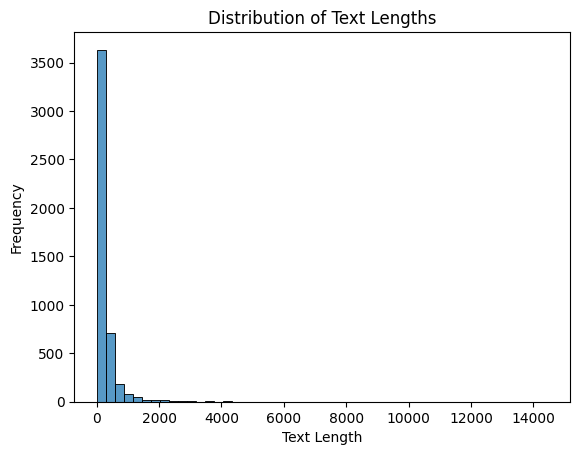

In [17]:
traindf['text_length'] = traindf['combined_text'].apply(len)
print(traindf['text_length'].describe())

sns.histplot(traindf['text_length'], bins=50)
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Distribution of Text Lengths')
plt.show()

In [18]:
class CustomTextDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        text =  str(self.dataframe.iloc[index]['combined_text'])
        label = self.dataframe.iloc[index]['label']


        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            truncation=True,
            return_tensors='pt',
            return_attention_mask=True,
            padding='max_length'
        )

        input_ids = encoding['input_ids'].flatten()
        attention_mask = encoding['attention_mask'].flatten()

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'label': torch.tensor(label, dtype=torch.long)
        }

In [19]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [20]:
ttrain_dataset = CustomTextDataset(traindf, tokenizer, max_length=300)
tvalid_dataset = CustomTextDataset(validdf, tokenizer, max_length=300)


In [21]:
batch_size=28
ttrain_loader = DataLoader(ttrain_dataset, batch_size, shuffle=True)
tvalid_loader = DataLoader(tvalid_dataset, batch_size, shuffle=False)

In [22]:
print(len(ttrain_loader))
print(len(tvalid_loader))

170
19


In [23]:
text_models=[]


In [24]:
criterion = nn.CrossEntropyLoss()
num_classes = 2
num_iters= 30000
num_epochs = num_iters / (len(ttrain_dataset) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

176


In [25]:
class BertClassifier(nn.Module):
    def __init__(self, bert_model_name, num_classes):
        super(BertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.dropout = nn.Dropout(0.2)
        self.relu = nn.ReLU()
        self.linear = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        logit = self.linear(pooled_output)
        return logit

tmodelBert = BertClassifier('bert-base-uncased', num_classes)
text_models.append(tmodelBert)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [26]:
class XLNetClassifier(nn.Module):
    def __init__(self, xlnet_model_name, num_classes):
        super(XLNetClassifier, self).__init__()
        self.xlnet = XLNetModel.from_pretrained(xlnet_model_name)
        self.dropout = nn.Dropout(0.2)
        self.relu = nn.ReLU()
        self.linear = nn.Linear(self.xlnet.config.d_model, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.xlnet(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0, :]
        pooled_output = self.dropout(pooled_output)
        logit = self.linear(pooled_output)
        return logit

tmodelXL = XLNetClassifier('xlnet-base-cased', num_classes)
text_models.append(tmodelXL)

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

In [27]:
text_models


[BertClassifier(
   (bert): BertModel(
     (embeddings): BertEmbeddings(
       (word_embeddings): Embedding(30522, 768, padding_idx=0)
       (position_embeddings): Embedding(512, 768)
       (token_type_embeddings): Embedding(2, 768)
       (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
       (dropout): Dropout(p=0.1, inplace=False)
     )
     (encoder): BertEncoder(
       (layer): ModuleList(
         (0-11): 12 x BertLayer(
           (attention): BertAttention(
             (self): BertSdpaSelfAttention(
               (query): Linear(in_features=768, out_features=768, bias=True)
               (key): Linear(in_features=768, out_features=768, bias=True)
               (value): Linear(in_features=768, out_features=768, bias=True)
               (dropout): Dropout(p=0.1, inplace=False)
             )
             (output): BertSelfOutput(
               (dense): Linear(in_features=768, out_features=768, bias=True)
               (LayerNorm): LayerNorm((768,),

In [28]:
text_model_name=["bert", "xlnet"]


In [29]:
ttrain_loss_history0 = []
ttrain_acc_history0 = []
ttest_loss_history0 = []
ttest_acc_history0 = []

ttrain_loss_history1 = []
ttrain_acc_history1= []
ttest_loss_history1 = []
ttest_acc_history1 = []

In [30]:
learning_rate = 0.0001
momentum = 0.9
beta_2 = 0.999
epsilon = 1e-8
weight_decay = 0.0
amsgrad = False

In [31]:
def callbacks_check():
    num_classes = 6
    accuracy_threshold = 0.99

    class MyCallback:
        def __init__(self):
            self.best_accuracy = 0.0

        def on_epoch_end(self, epoch, accuracy):
            if accuracy > accuracy_threshold:
                print("\nReached {:.2f}% accuracy, so we will stop training".format(accuracy_threshold * 100))
                return True
            return False

    acc_callback = MyCallback()

    return acc_callback

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [33]:
for idx, model in enumerate(text_models):
    
    print("===============> ",text_model_name[idx], "<===================")
    model.to(device)
    optimizer = optim.AdamW(model.parameters(),
                           lr=learning_rate)

    iter= 0
    patience = 10
    best_val_loss = float('inf')
    counter = 0


    callback_list = callbacks_check()

    for epoch in range(num_epochs):
        
        model.train()   
        total_loss = 0
        correct_predictions = 0
        total_samples = 0
        
        for batch in ttrain_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()
            logits = model(input_ids, attention_mask)
            
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(logits, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

        avg_loss = total_loss / len(ttrain_loader)
        train_accuracy = correct_predictions / total_samples

        if idx==0:
            ttrain_loss_history0.append(avg_loss)
            ttrain_acc_history0.append(train_accuracy)

        else:
            ttrain_loss_history1.append(avg_loss)
            ttrain_acc_history1.append(train_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_loss:.4f} - Train Accuracy: {train_accuracy:.4f}")
        
        model.eval()
        val_loss_total = 0
        val_correct_predictions = 0
        val_total_samples = 0

        with torch.no_grad():
            for batch in tvalid_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['label'].to(device)

                logits = model(input_ids, attention_mask)
                preds = torch.argmax(logits, dim=1)

                val_loss = criterion(logits, labels)
                val_loss_total += val_loss.item()
                
                _, val_predicted = torch.max(logits, 1)
                val_correct_predictions += (val_predicted == labels).sum().item()
                val_total_samples += labels.size(0)

        val_loss_avg = val_loss_total / len(tvalid_loader)
        val_accuracy = val_correct_predictions / val_total_samples

        if idx==0:
            ttest_loss_history0.append(val_loss_avg)
            ttest_acc_history0.append(val_accuracy)

        else:
            ttest_loss_history1.append(val_loss_avg)
            ttest_acc_history1.append(val_accuracy)

        print(f"Epoch [{epoch + 1}/{num_epochs}] - Validation Loss: {val_loss_avg:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        if callback_list.on_epoch_end(epoch+1,train_accuracy):
            print(print("Early stopping triggered at epoch",epoch+1))
            break

        elif (val_loss_avg < best_val_loss):
            best_val_loss = val_loss_avg
            counter = 0
            torch.save(model.state_dict(),'text_{}_best_model.pt'.format(idx))
            print("Model saved")
            model.train()

        else:
            counter += 1
            if counter >= patience:
                print(f'Early stopping at epoch {epoch + 1}.')
                break
    print("-------------------------------------------------------------")

print("###################### Training Complete ########################")

===============>  bert <===================
Epoch [1/176] - Train Loss: 0.3259 - Train Accuracy: 0.8596
Epoch [1/176] - Validation Loss: 0.3079, Validation Accuracy: 0.8731
Model saved
Epoch [2/176] - Train Loss: 0.2471 - Train Accuracy: 0.9051
Epoch [2/176] - Validation Loss: 0.2792, Validation Accuracy: 0.8807
Model saved
Epoch [3/176] - Train Loss: 0.2154 - Train Accuracy: 0.9219
Epoch [3/176] - Validation Loss: 0.3670, Validation Accuracy: 0.8542
Epoch [4/176] - Train Loss: 0.1747 - Train Accuracy: 0.9369
Epoch [4/176] - Validation Loss: 0.2748, Validation Accuracy: 0.8845
Model saved
Epoch [5/176] - Train Loss: 0.1606 - Train Accuracy: 0.9432
Epoch [5/176] - Validation Loss: 0.6214, Validation Accuracy: 0.8163
Epoch [6/176] - Train Loss: 0.3488 - Train Accuracy: 0.8586
Epoch [6/176] - Validation Loss: 0.6853, Validation Accuracy: 0.6856
Epoch [7/176] - Train Loss: 0.6779 - Train Accuracy: 0.6069
Epoch [7/176] - Validation Loss: 0.6459, Validation Accuracy: 0.6572
Epoch [8/176] - T

In [58]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def evaluate_model(model, data_loader, criterion, device):
    model.eval() 
    total_loss = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels)
            total_loss += loss.item()

            preds = torch.argmax(logits, dim=1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(preds.cpu().numpy())

    avg_loss = total_loss / len(data_loader)
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    conf_matrix = confusion_matrix(all_labels, all_predictions)

    return avg_loss, accuracy, precision, recall, f1, conf_matrix

for idx, model in enumerate(text_models):
    print("===============> Evaluating ", text_model_name[idx], "<===================")
    model.load_state_dict(torch.load(f'text_{idx}_best_model.pt'))
    model.to(device)
    
    val_loss, val_accuracy, val_precision, val_recall, val_f1, val_conf_matrix = evaluate_model(model, tvalid_loader, criterion, device)
    
    print(f"Validation Loss: {val_loss:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    print(f"Validation Precision: {val_precision:.4f}")
    print(f"Validation Recall: {val_recall:.4f}")
    print(f"Validation F1 Score: {val_f1:.4f}")
    print("Confusion Matrix:")
    print(val_conf_matrix)

print("###################### Evaluation Complete ########################")


===============> Evaluating  bert <===================
Validation Loss: 0.2748
Validation Accuracy: 0.8845
Validation Precision: 0.8926
Validation Recall: 0.8845
Validation F1 Score: 0.8861
Confusion Matrix:
[[303  44]
 [ 17 164]]
===============> Evaluating  xlnet <===================
Validation Loss: 0.3082
Validation Accuracy: 0.8883
Validation Precision: 0.8946
Validation Recall: 0.8883
Validation F1 Score: 0.8897
Confusion Matrix:
[[306  41]
 [ 18 163]]
###################### Evaluation Complete ########################


===============> Evaluating  bert <===================
Validation Loss: 0.2748


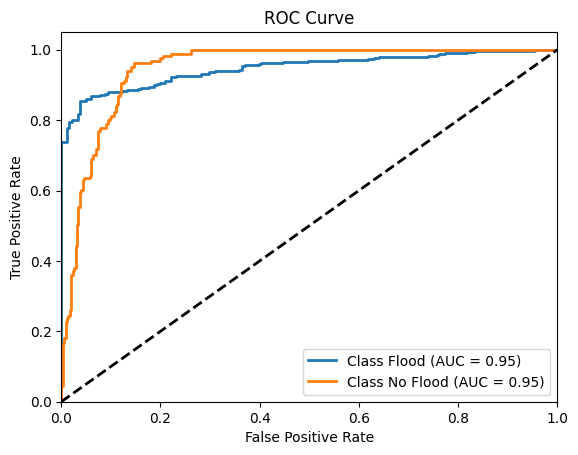

===============> Evaluating  xlnet <===================
Validation Loss: 0.3082


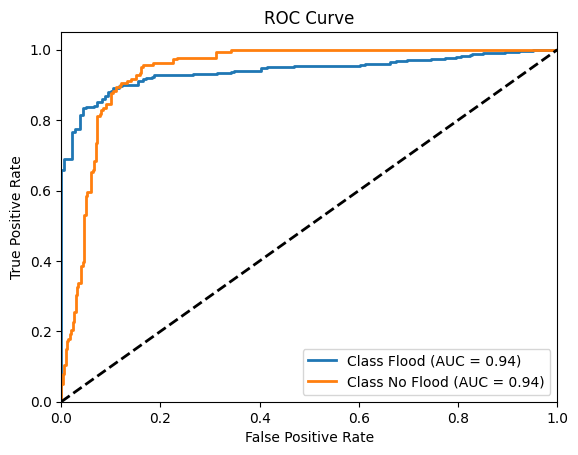

In [59]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
import numpy as np

def evaluate_model(model, data_loader, criterion, device, class_names):
    model.eval()  
    total_loss = 0
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels)
            total_loss += loss.item()

            probs = torch.softmax(logits, dim=1)
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    avg_loss = total_loss / len(data_loader)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    try:
        overall_auc = roc_auc_score(all_labels, all_probs, multi_class='ovr', average='weighted')
    except ValueError:
        overall_auc = float('nan')

    return avg_loss, overall_auc, all_labels, all_probs

def plot_roc_curve(labels, probs, class_names):
    n_classes = len(class_names)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(labels == i, probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curves
    plt.figure()
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {class_names[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

# Example usage:
class_names = ["Flood", "No Flood"]  # Replace with your actual class names

for idx, model in enumerate(text_models):
    print("===============> Evaluating ", text_model_name[idx], "<===================")
    model.load_state_dict(torch.load(f'text_{idx}_best_model.pt'))
    model.to(device)
    
    val_loss, val_auc, val_labels, val_probs = evaluate_model(model, tvalid_loader, criterion, device, class_names)
    
    print(f"Validation Loss: {val_loss:.4f}")
    plot_roc_curve(val_labels, val_probs, class_names)


